In [1]:
from scipy.interpolate import UnivariateSpline
import os
import json
import torch
from torchmin import minimize
import matplotlib.pyplot as plt
import numpy as np


def exponential_velocity_decay_model(
    time, initial_velocity, initial_position, velocity_decay_factor
):
    position = [initial_position]
    velocity = [initial_velocity]
    for i in range(len(time) - 1):
        position.append(position[i] + velocity[i] * (time[i + 1] - time[i]))
        velocity.append(velocity[i] * velocity_decay_factor)
    return torch.concatenate(position)


def linear_friction_model(
    time, initial_velocity, initial_position, velocity_decay_factor
):
    position = [initial_position]
    velocity = [initial_velocity]
    for i in range(len(time) - 1):
        position.append(position[i] + velocity[i] * (time[i + 1] - time[i]))
        velocity.append(
            velocity[i] - velocity_decay_factor * torch.sign(velocity[i]) * (time[i + 1] - time[i])
            if velocity_decay_factor * (time[i + 1] - time[i]) < torch.abs(velocity[i])
            else torch.tensor([0.0])
        )
    return torch.concatenate(position)


def estimate_initial_velocity(time, positions, n_points=3):
    velocity = torch.zeros(n_points, 1)
    for i in range(n_points):
        velocity[i, :] = (positions[i + 1] - positions[i]) / (time[i + 1] - time[i])
    return torch.mean(velocity, dim=0)


def reduce_to_distances(positions):
    distances = torch.sqrt(torch.sum((positions[1:] - positions[:-1]) ** 2, dim=1))
    return torch.concatenate((torch.tensor([0.0]), distances.cumsum(dim=0)))


# Smooth position data using a moving average filter
def moving_average(time, points, w):
    points = points.T.unsqueeze(1)
    filtered_points = torch.conv1d(points, torch.ones(1, 1, w) / w, padding=0)
    return time[w // 2 - 1 : -w // 2], filtered_points.squeeze().T


def load_data(data_path, smooth_data=True, reduce=True, filter_no_movement=True):
    file_list = os.listdir(data_path)
    time_data = []
    position_data = []
    file_names = []
    for file in file_list:
        file_path = data_path + file
        with open(file_path, "r") as f:
            json_data = json.load(f)
            positions = torch.tensor(
                [json_data[i][0]["position"] for i in range(len(json_data))]
            )
            time = torch.tensor(
                [json_data[i][0]["time"] for i in range(len(json_data))]
            )
            time = time - time[0]
            moving_average_window = 5

            if smooth_data:
                time, positions = moving_average(time, positions, moving_average_window)
            if reduce:
                positions = reduce_to_distances(positions)
            if filter_no_movement and file == "no_movement.json":
                continue
            time_data.append(time)
            position_data.append(positions)
            file_names.append(file)

    return time_data, position_data, file_names


def load_data_spline_smoothing(
    data_path, reduce=True, smooth_data=True, filter_no_movement=True
):
    file_list = os.listdir(data_path)
    time_data = []
    position_data = []
    file_names = []
    for file in file_list:
        file_path = data_path + file
        with open(file_path, "r") as f:
            json_data = json.load(f)
            positions = np.array(
                [json_data[i][0]["position"] for i in range(len(json_data))]
            )
            time = np.array([json_data[i][0]["time"] for i in range(len(json_data))])
            time = time - time[0]
            if filter_no_movement and file == "no_movement.json":
                continue
            if smooth_data:
                distance = np.cumsum(
                    np.sqrt(np.sum((positions[1:] - positions[:-1]) ** 2, axis=1))
                )
                distance = np.insert(distance, 0, 0) / distance[-1]
                splines = [
                    UnivariateSpline(distance, coordinates, k=3, s=0.2)
                    for coordinates in positions.T
                ]
                alpha = np.linspace(0, 1, 10000)
                spline_positions = np.vstack([spline(alpha) for spline in splines]).T
                # Calculate pairwise distances between spline_positions and positions and find the closest match
                distances = np.sqrt(
                    np.sum(
                        (spline_positions[:, None, :] - positions[None, :, :]) ** 2,
                        axis=-1,
                    )
                )
                closest_match = np.argmin(distances, axis=0)
                positions = spline_positions[closest_match]
                positions = torch.from_numpy(positions)
            if reduce:
                positions = reduce_to_distances(positions)
            time_data.append(torch.from_numpy(time))
            position_data.append(positions)
            file_names.append(file)

    return time_data, position_data, file_names


def load_data_time_spline_smoothing(
    data_path, reduce=True, smooth_data=True, filter_no_movement=True
):
    file_list = os.listdir(data_path)
    time_data = []
    position_data = []
    file_names = []
    for file in file_list:
        file_path = data_path + file
        with open(file_path, "r") as f:
            json_data = json.load(f)
            positions = np.array(
                [json_data[i][0]["position"] for i in range(len(json_data))]
            )
            time = np.array([json_data[i][0]["time"] for i in range(len(json_data))])
            time = time - time[0]
            if filter_no_movement and file == "no_movement.json":
                continue
            if smooth_data:
                time_positions = np.vstack([time, positions.T]).T
                distance = np.cumsum(
                    np.sqrt(
                        np.sum((time_positions[1:] - time_positions[:-1]) ** 2, axis=1)
                    )
                )
                distance = np.insert(distance, 0, 0) / distance[-1]
                splines = [
                    UnivariateSpline(distance, coordinates, k=3, s=0.1)
                    for coordinates in time_positions.T
                ]
                alpha = np.linspace(0, 1, time.shape[0])
                spline_positions = np.vstack([spline(alpha) for spline in splines]).T
                positions = torch.from_numpy(spline_positions[:, 1:])
                time = torch.from_numpy(spline_positions[:, 0])
            if reduce:
                positions = reduce_to_distances(positions)
            time_data.append(time)
            position_data.append(positions)
            file_names.append(file)

    return time_data, position_data, file_names

 
time_data, position_data, _ = load_data_time_spline_smoothing("data/")
time_data[0].shape, position_data[0].shape

(torch.Size([59]), torch.Size([59]))

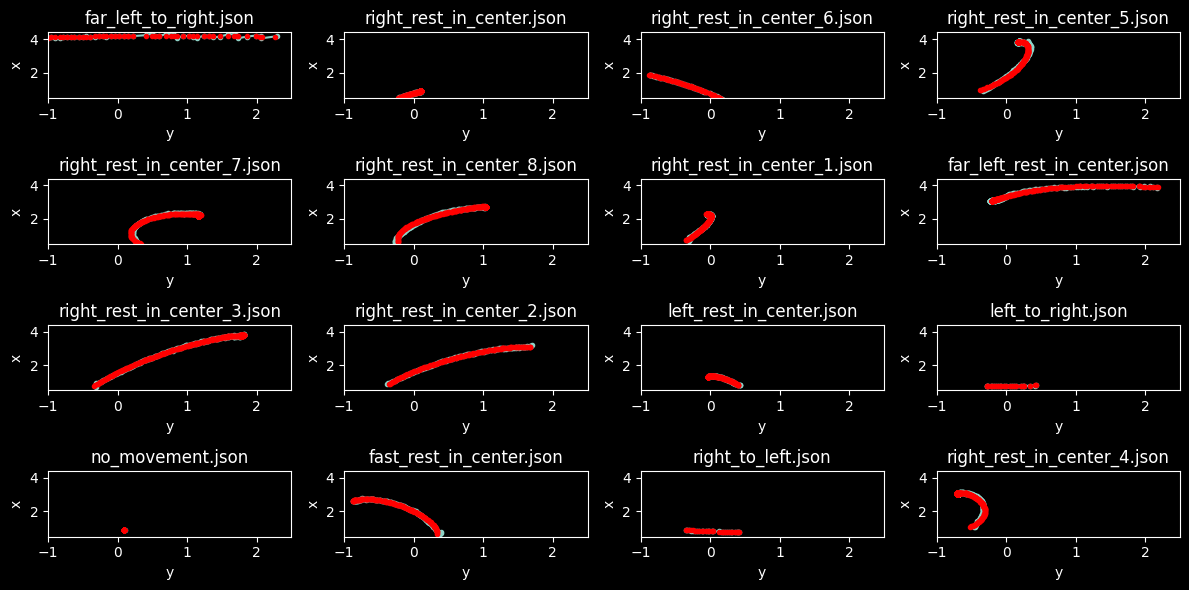

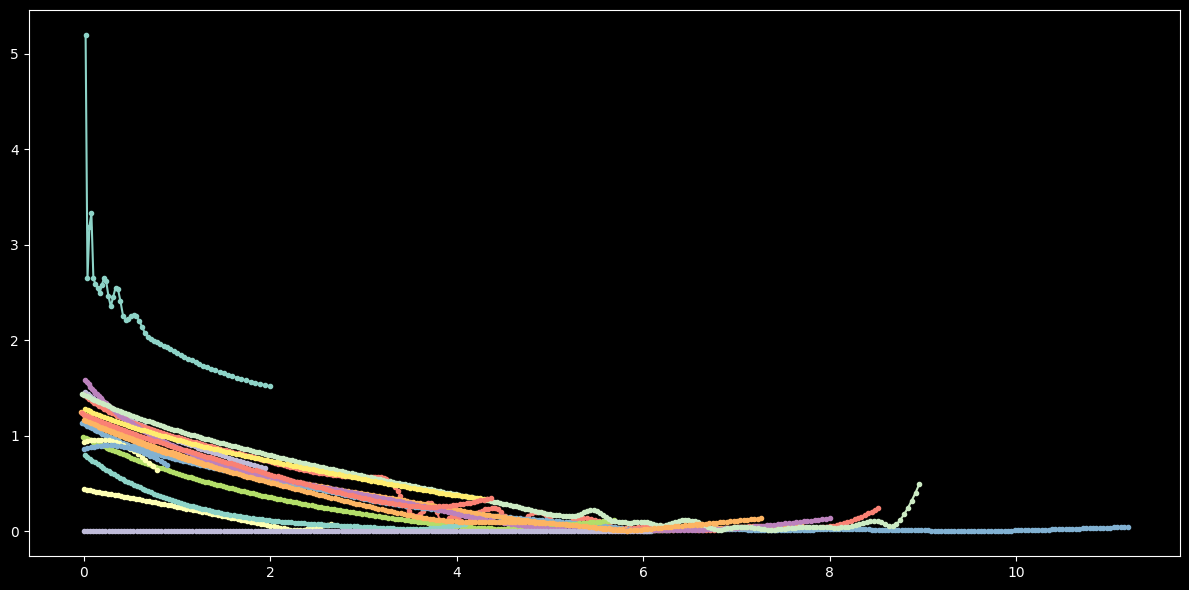

In [2]:
def plot_trajectories(data_path):
    _, position_data, file_names = load_data_time_spline_smoothing(
        data_path, reduce=False, smooth_data=False, filter_no_movement=False
    )
    # Plot all eight trajectories in a grid of subplots
    _, axs = plt.subplots(len(file_names) // 4, 4, figsize=(12, 6))
    for i in range(len(file_names)):
        axs[i // 4, i % 4].plot(position_data[i][:, 1], position_data[i][:, 0], ".-")
        axs[i // 4, i % 4].set_title(file_names[i])
        axs[i // 4, i % 4].set_xlabel("y")
        axs[i // 4, i % 4].set_ylabel("x")

    _, position_data, file_names = load_data_spline_smoothing(
        data_path, reduce=False, smooth_data=True, filter_no_movement=False
    )
    for i in range(len(file_names)):
        axs[i // 4, i % 4].plot(
            position_data[i][:, 1],
            position_data[i][:, 0],
            ".",
            color="red",
        )
        axs[i // 4, i % 4].set_title(file_names[i])
        axs[i // 4, i % 4].set_xlabel("y")
        axs[i // 4, i % 4].set_ylabel("x")
        axs[i // 4, i % 4].set_xlim([-1, 2.5])
        axs[i // 4, i % 4].set_ylim([0.5, 4.4])
    plt.tight_layout()


def plot_velocity(data_path):
    time_data, position_data, file_names = load_data_time_spline_smoothing(
        data_path, reduce=True, smooth_data=True, filter_no_movement=False
    )
    # Plot all eight trajectories in a grid of subplots
    # _, axs = plt.subplots(2, 4, figsize=(12, 6))
    plt.figure(figsize=(12, 6))
    for i in range(len(file_names)):
        velocity = (position_data[i][1:] - position_data[i][:-1]) / (
            time_data[i][1:] - time_data[i][:-1]
        )
        # axs[i // 4, i % 4].plot(time_data[i][:-1], velocity, ".-")
        plt.plot(time_data[i][:-1], velocity, ".-")
        # axs[i // 4, i % 4].set_title(file_names[i])

        # axs[i // 4, i % 4].set_xlim([-1, 2.5])
        # axs[i // 4, i % 4].set_ylim([0.0, 5.0])
    plt.tight_layout()


data_path = "data/"

plot_trajectories(data_path)
plot_velocity(data_path)

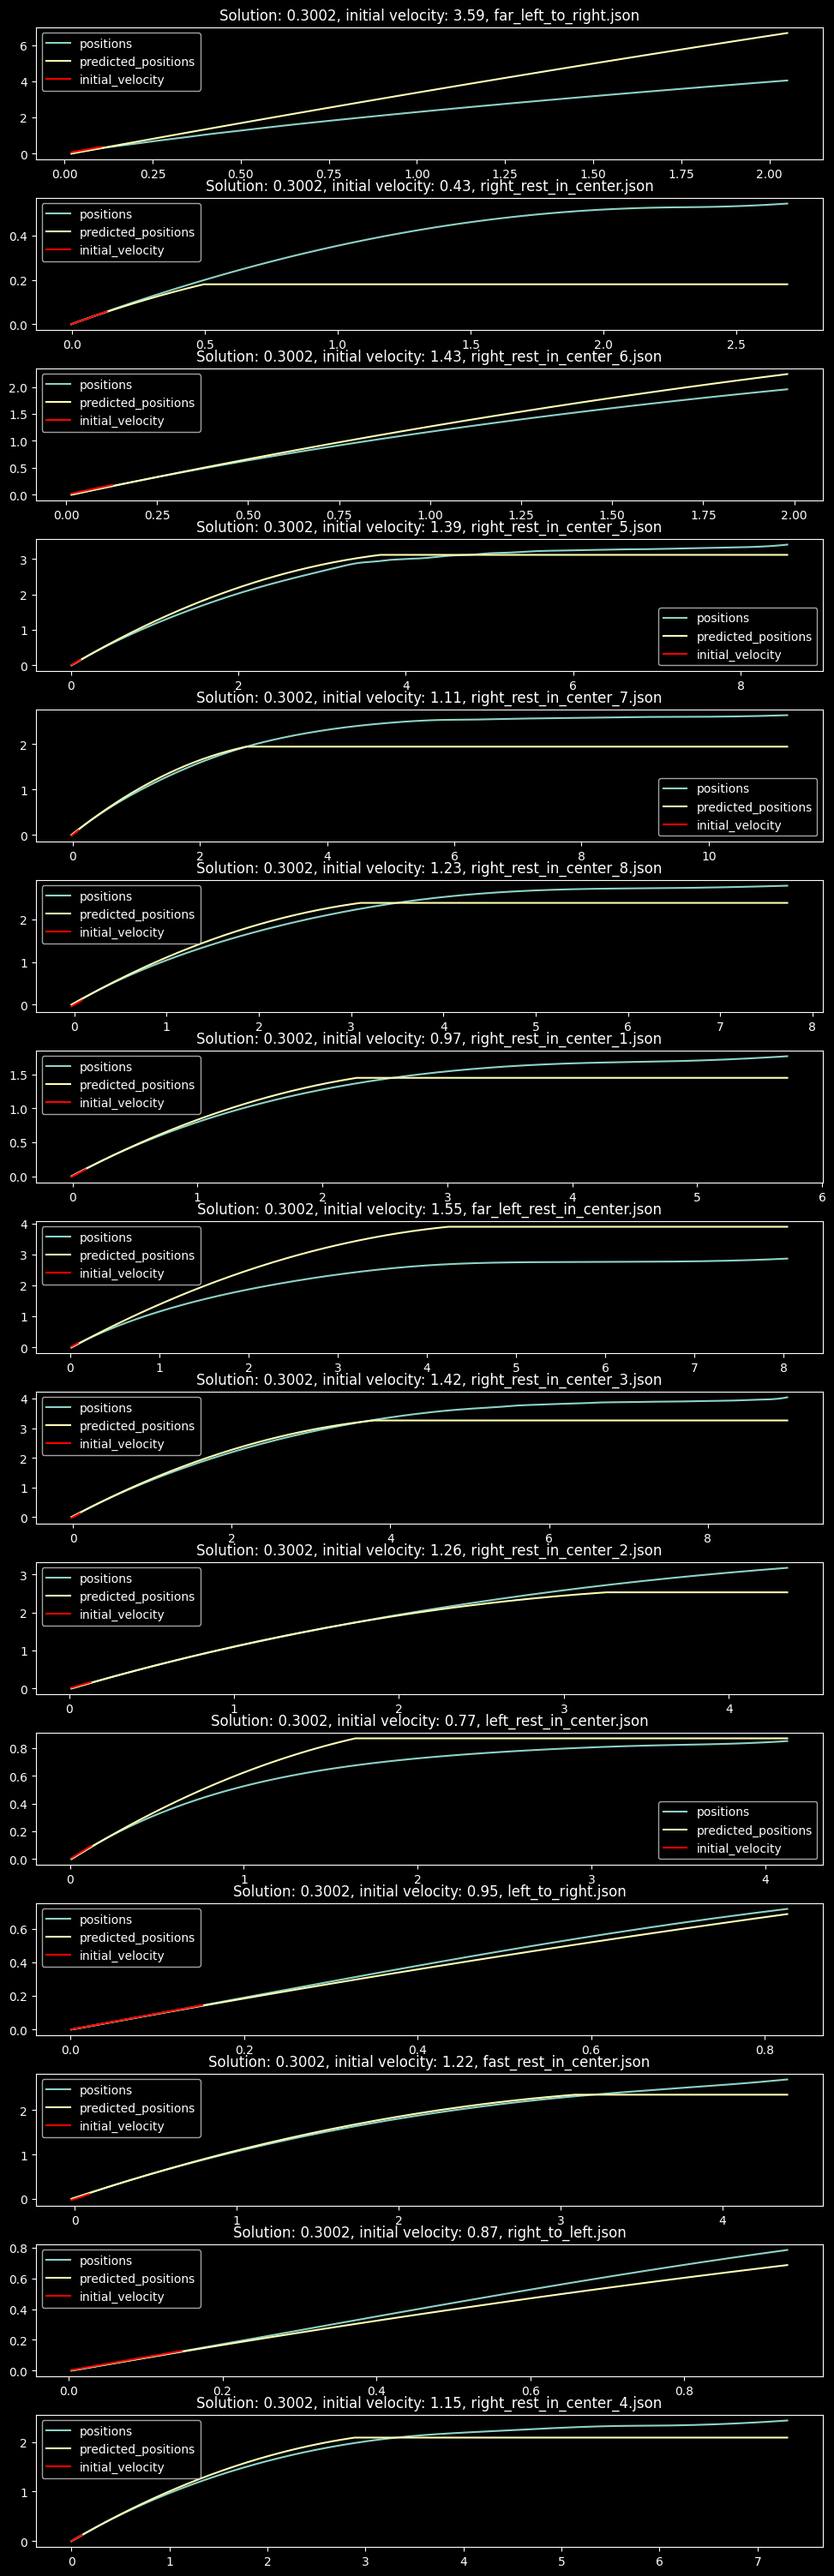

In [4]:
time_data, position_data, file_names = load_data_time_spline_smoothing(data_path)


def noise_slope(time_data, position_data, file_names):
    for time, positions, file_name in zip(time_data, position_data, file_names):
        if file_name == "no_movement.json":
            slope = (positions[-1] - positions[0]) / (time[-1] - time[0])
    return slope


def model_loss(time, positions, velocity_decay_factor, model):
    initial_velocity = estimate_initial_velocity(time, positions, 4)
    initial_position = positions[0].reshape((1,))
    predicted_positions = model(
        time, initial_velocity, initial_position, velocity_decay_factor
    )
    residuals = predicted_positions - positions
    loss = torch.mean(torch.abs(residuals)**2)
    return loss, predicted_positions


def combined_trajectory_loss(velocity_decay_factor, model=linear_friction_model):
    loss = torch.zeros((1,))
    for time, positions in zip(time_data, position_data):
        trajectory_loss, _ = model_loss(time, positions, velocity_decay_factor, model)
        loss += trajectory_loss
    return loss


model = linear_friction_model
initial_velocity_decay_factor = 0.3
result = minimize(
    lambda velocity_decay_factor: combined_trajectory_loss(
        velocity_decay_factor, model
    ),
    initial_velocity_decay_factor,
    method="bfgs",
    tol=1e-9,
)
best_decay_factor = torch.clamp(result.x, min=0.0)

fig, axes = plt.subplots(len(time_data), 1, figsize=(10, 30))
fig.tight_layout()
for j, (time, positions, file_name) in enumerate(
    zip(time_data, position_data, file_names)
):
    _, predicted_positions = model_loss(time, positions, best_decay_factor, model)
    initial_velocity = estimate_initial_velocity(time, positions, 4)
    axes[j].plot(time, positions, label="positions")
    axes[j].plot(time, predicted_positions, label="predicted_positions")
    axes[j].plot(time[:5], initial_velocity * time[:5], "r", label="initial_velocity")
    axes[j].set_title(
        f"Solution: {best_decay_factor:.4f}, initial velocity: {float(initial_velocity):.2f}, {file_name}"
    )
    axes[j].legend()